In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
from matplotlib import cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from carbonplan_styles.mpl import set_theme
set_theme()
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import seaborn as sns
import pandas as pd
from carbonplan_trace.tiles import tiles


# Get comparison data


In [2]:
from carbonplan_trace.v1.landsat_preprocess import access_credentials
import fsspec

access_key_id, secret_access_key = access_credentials()
fs = fsspec.get_filesystem_class("s3")(
    key=access_key_id,
    secret=secret_access_key,
)

In [2]:
version = "v1.2"

In [ ]:
ds = xr.open_zarr(
    f"s3://carbonplan-climatetrace/{version}/results/global/3000m/raster_biomass.zarr"
)
# average carbonplan data for comparison since all other datasets are ~snapshots
ds = ds.mean(dim="time").compute()
# rename
ds = ds[["AGB"]].rename({"AGB": "CarbonPlan"})
ds = ds.assign_coords({"lat": ds.lat.round(4), "lon": ds.lon.round(4)})

In [ ]:
comps = ["Harris", "Spawn", "GEDI"]
for name in comps:
    temp = xr.open_zarr(f"s3://carbonplan-climatetrace/validation/{name.lower()}_3000m_agbd.zarr")
    temp = temp.assign_coords({"lat": ds.lat, "lon": ds.lon})
    ds[name] = temp["agbd"]

In [ ]:
# also load realm
realms = xr.open_zarr("s3://carbonplan-climatetrace/validation/realm_mask.zarr")
realms = realms.assign_coords({"lat": realms.lat.round(4), "lon": realms.lon.round(4)})
ds["realm"] = realms.realm

In [ ]:
ds

In [ ]:
# mask to land only
land_mask = xr.open_zarr("s3://carbonplan-climatetrace/validation/land_mask.zarr")
land_mask = land_mask.assign_coords({"lat": land_mask.lat.round(4), "lon": land_mask.lon.round(4)})
ds = ds.where(land_mask.land_mask == 0)

# Maps


In [ ]:
from cartopy.io import shapereader
import geopandas as gpd


def cartopy_proj_plate_carree():
    return ccrs.PlateCarree()


def cartopy_borders_global():
    states_df = gpd.read_file(
        shapereader.natural_earth("50m", "cultural", "admin_1_states_provinces")
    )
    states = states_df.set_crs(epsg=4326).to_crs(epsg=32662)["geometry"].values

    countries_df = gpd.read_file(shapereader.natural_earth("50m", "cultural", "admin_0_countries"))
    countries = countries_df.set_crs(epsg=4326).to_crs(epsg=32662)["geometry"].values

    return states, countries

In [ ]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


def map_pretty(ax, title="", min_lat=-90, max_lat=90, min_lon=-180, max_lon=180):
    state_borders, country_borders = cartopy_borders_global()

    ax.add_geometries(
        state_borders,
        facecolor="none",
        edgecolor="k",
        crs=cartopy_proj_plate_carree(),
        linewidth=0.1,
        zorder=0,
    )
    ax.add_geometries(
        country_borders,
        facecolor="none",
        edgecolor="k",
        crs=cartopy_proj_plate_carree(),
        linewidth=0.3,
        zorder=0,
    )
    ax.axis("off")
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])
    ax.text(0.35, 1.05, title, transform=ax.transAxes)


def add_colorbar(
    fig,
    to_plot=None,
    x_location=1.08,
    y_location=0.76,
    height=0.12,
    width=0.018,
    vmin=None,
    vmax=None,
    cbar_label="",
    cmap="viridis",
):

    cax = fig.add_axes([x_location, y_location, width, height])
    cax.text(
        0.5,
        -0.08,
        vmin,
        transform=cax.transAxes,
        horizontalalignment="center",
        verticalalignment="center",
    )
    cax.text(
        0.5,
        1.08,
        vmax,
        transform=cax.transAxes,
        horizontalalignment="center",
        verticalalignment="center",
    )
    cax.text(
        1.8,
        0.5,
        cbar_label,
        transform=cax.transAxes,
        verticalalignment="center",
        multialignment="center",
        rotation=-90,
    )
    if to_plot is not None:
        cbar = fig.colorbar(to_plot, cax=cax, orientation="vertical")
    else:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
            cax=cax,
            orientation="vertical",
        )
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    return cbar

In [ ]:
def plot_map(data, names, titles, plot_params):
    vmin, vmax = plot_params["var_lims"][0], plot_params["var_lims"][1]

    plt.figure(figsize=(20, 10))
    for i, name in enumerate(names):
        if name is None:
            continue
        da = data[name]
        plt.subplot(nrows, ncols, i + 1, projection=cartopy_proj_plate_carree())
        ax = plt.gca()

        map_plot = da.plot.imshow(
            ax=ax,
            cmap=plot_params["cmap"],
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False,
            transform=ccrs.PlateCarree(),
        )

        map_pretty(
            ax,
            title=titles[i],
        )

    fig = plt.gcf()
    cax = fig.add_axes([1.05, 0.33, 0.03, 0.35])
    cbar = fig.colorbar(map_plot, cax=cax, orientation="vertical")
    cax.text(
        0.5,
        -0.12,
        plot_params["var_lims"][0],
        transform=cax.transAxes,
        horizontalalignment="center",
    )
    cax.text(
        0.5,
        1.05,
        plot_params["var_lims"][1],
        transform=cax.transAxes,
        horizontalalignment="center",
    )
    cax.text(
        1.8,
        0.5,
        plot_params["label"],
        transform=cax.transAxes,
        verticalalignment="center",
        multialignment="center",
        rotation=-90,
    )
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
nrows = 2
ncols = 2
names = ["CarbonPlan"] + comps
titles = [
    "CarbonPlan (2014-2020)",
    "Harris (2000)",
    "Spawn (2010)",
    "GEDI (2019-2020)",
]
plot_params = {
    "cmap": cm.Greens,
    "var_lims": (0, 500),
    "label": "Aboveground Woody Biomass Density (Mg/ha)",
}

plot_map(data=ds, names=names, titles=titles, plot_params=plot_params)

In [ ]:
abs_diff = xr.Dataset()
for name in comps:
    abs_diff[name] = ds["CarbonPlan"] - ds[name]

In [ ]:
nrows = 2
ncols = 2
names = [None] + comps
titles = [
    None,
    "Difference to Harris",
    "Difference to Spawn",
    "Difference to GEDI",
]
plot_params = {
    "cmap": cm.RdBu,
    "var_lims": (-200, 200),
    "label": "Absolute Difference in Biomass Density (Mg/ha)",
}

plot_map(data=abs_diff, names=names, titles=titles, plot_params=plot_params)

In [ ]:
pct_diff = xr.Dataset()
for name in comps:
    pct_diff[name] = 100.0 * (ds["CarbonPlan"] - ds[name]) / ds[name]

In [ ]:
nrows = 2
ncols = 2
names = [None] + comps
titles = [
    None,
    "Difference to Harris",
    "Difference to Spawn",
    "Difference to GEDI",
]
plot_params = {
    "cmap": cm.RdBu,
    "var_lims": (-200, 200),
    "label": "Percent Difference in Biomass Density (%)",
}

plot_map(data=pct_diff, names=names, titles=titles, plot_params=plot_params)

# Scatter plots


In [ ]:
df = ds.to_dataframe()
df["realm"] = df.realm.replace(["nan", "ice"], np.nan)

In [ ]:
def subplot_hist(
    ax,
    x_col,
    y_col,
    x_name,
    y_name,
    plot_params,
    #     c="b",
    #     s=0.002,
    #     alpha=0.1,
):
    #     tot = np.hstack((x_col, y_col))
    #     xmax = np.percentile(tot, 99.5)
    xmin = plot_params["xmin"]
    xmax = plot_params["xmax"]
    unit = plot_params["unit"]

    ax.plot([xmin, xmax], [xmin, xmax], "0.5")
    bias = np.mean(ycol - xcol)
    r2 = r2_score(x_col, y_col)
    mae = mean_absolute_error(x_col, y_col)

    #     ax.scatter(x_col, y_col, c=c, s=s, alpha=alpha, marker="o")
    ind = (xcol < xmax) & (ycol < xmax)
    sns.histplot(ax=ax, x=xcol[ind], y=ycol[ind], bins=100, pthresh=0.01, pmax=0.3)
    ax.text(plot_params["text_x"], xmax * 0.9, f"bias = {round(bias, 2)} {unit}")
    ax.text(plot_params["text_x"], xmax * 0.81, f"MAE = {round(mae, 2)} {unit}")
    ax.text(plot_params["text_x"], xmax * 0.72, f"R$^2$ = {round(r2, 2)}")
    if unit != "":
        unit_str = f"({unit})"
    else:
        unit_str = ""
    ax.set_xlabel(f"Biomass from {x_name} {unit_str}")
    ax.set_ylabel(f"Biomass from {y_name} {unit_str}")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    ticks = np.arange(0, xmax, 100)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

In [ ]:
plot_params = {
    "xmin": -10,
    "xmax": 510,
    "unit": "Mg/ha",
    "text_x": 10,
    #     "text_y1": 450,
    #     "text_y2": 420,
    #     "text_y3": 390,
    #     "ticks": np.arange(0, 510, 100),
}

In [ ]:
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, name in enumerate(comps):
    sub = df[["CarbonPlan", name]].dropna(how="any")
    ycol = sub["CarbonPlan"].values
    xcol = sub[name].values
    subplot_hist(
        ax=axarr[i],
        x_col=xcol,
        y_col=ycol,
        x_name=name,
        y_name="CarbonPlan",
        plot_params=plot_params,
    )
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
realms = df.realm.dropna().unique()

In [ ]:
fig, axarr = plt.subplots(nrows=6, ncols=3, figsize=(15, 30))
for i, realm in enumerate(realms):
    for j, name in enumerate(comps):
        sub = df.loc[df.realm == realm][["CarbonPlan", name]].dropna(how="any")
        ycol = sub["CarbonPlan"].values
        xcol = sub[name].values
        subplot_hist(
            ax=axarr[i, j],
            x_col=xcol,
            y_col=ycol,
            x_name=name,
            y_name="CarbonPlan",
            plot_params=plot_params,
        )
        if j == 1:
            axarr[i, j].set_title(realm)
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
def subplot_kde(
    ax,
    data,
    x_col_name,
    y_col_name,
    hue_name,
    x_name,
    y_name,
    plot_params,
):
    xmin = plot_params["xmin"]
    xmax = plot_params["xmax"]
    unit = plot_params["unit"]

    ax.plot([xmin, xmax], [xmin, xmax], "0.5")
    x_col = data[x_col_name].values
    y_col = data[y_col_name].values
    bias = np.mean(ycol - xcol)
    r2 = r2_score(x_col, y_col)
    mae = mean_absolute_error(x_col, y_col)

    sub = data.loc[(data[x_col_name] < xmax) & (data[y_col_name] < xmax)].sample(int(1e6))
    sns.kdeplot(data=sub, x=name, y="CarbonPlan", hue="realm", levels=7, linewidth=0.5, ax=ax)
    ax.text(plot_params["text_x"], xmax * 0.9, f"bias = {round(bias, 2)} {unit}")
    ax.text(plot_params["text_x"], xmax * 0.81, f"MAE = {round(mae, 2)} {unit}")
    ax.text(plot_params["text_x"], xmax * 0.72, f"R$^2$ = {round(r2, 2)}")
    if unit != "":
        unit_str = f"({unit})"
    else:
        unit_str = ""
    ax.set_xlabel(f"Biomass from {x_name} {unit_str}")
    ax.set_ylabel(f"Biomass from {y_name} {unit_str}")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    ticks = np.arange(0, xmax, 100)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

In [ ]:
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, name in enumerate(comps):
    sub = df[["CarbonPlan", name, "realm"]].dropna(how="any")

    subplot_kde(
        ax=axarr[i],
        data=sub,
        x_col_name=name,
        y_col_name="CarbonPlan",
        hue_name="realm",
        x_name=name,
        y_name="CarbonPlan",
        plot_params=plot_params,
    )
plt.tight_layout()
plt.show()
plt.close()

# country level comparisons


In [32]:
df = pd.read_csv(f"s3://carbonplan-climatetrace/{version}/country_rollups_AGB.csv")
df = df.groupby("iso3_country").agbd.mean().reset_index()
df = df.rename(columns={"agbd": "CarbonPlan"})

In [33]:
comps = ["Harris", "Spawn", "GEDI"]
for name in comps:
    temp = pd.read_csv(
        f"s3://carbonplan-climatetrace/validation/{name.lower()}_country_rollups_agbd.csv"
    )
    temp = temp.rename(columns={"agbd": name})
    df = df.merge(temp, on=["iso3_country"])

In [5]:
df.head()

,iso3_country,CarbonPlan,Harris,Spawn,GEDI
0,ABW,1.021245,1.060841,2.189218,3.434316
1,AFG,0.738528,0.855988,1.059667,23.863041
2,AGO,89.626021,63.206755,54.281637,32.015339
3,AIA,0.000000,19.433384,12.774334,1.788038
4,ALA,52.973730,44.449908,48.672792,0.000000


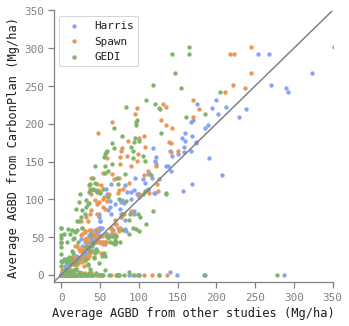

In [6]:
plt.figure(figsize=(5, 5))
for name in comps:
    plt.scatter(df[name].values, df.CarbonPlan.values, label=name, s=11)

xmin = -10
xmax = 350
plt.plot([xmin, xmax], [xmin, xmax], "0.5")
plt.legend()

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xlabel("Average AGBD from other studies (Mg/ha)")
plt.ylabel("Average AGBD from CarbonPlan (Mg/ha)")
plt.show()
plt.close()

In [7]:
df.loc[(df.CarbonPlan < 10) & (df.Harris > 50)]

,iso3_country,CarbonPlan,Harris,Spawn,GEDI
71,FJI,0.000000,185.708167,51.914279,126.381841
118,KNA,0.000000,100.778278,64.520645,23.896484
149,MSR,0.000000,87.676475,74.160086,61.135921
151,MUS,0.000000,100.005536,24.858342,38.802956
156,NCL,4.181442,139.779390,38.072139,86.864467
183,REU,0.000000,149.530633,24.328727,70.055288
194,SLB,0.000000,286.707641,136.231322,277.653127


In [8]:
df.loc[(df.CarbonPlan < 10) & (df.Spawn > 50)]

,iso3_country,CarbonPlan,Harris,Spawn,GEDI
10,ASM,0.000000,0.000000,116.511386,74.481228
71,FJI,0.000000,185.708167,51.914279,126.381841
75,FSM,0.000000,18.775710,95.096317,49.528454
118,KNA,0.000000,100.778278,64.520645,23.896484
146,MNP,0.000000,0.000000,72.104245,34.732974
149,MSR,0.000000,87.676475,74.160086,61.135921
194,SLB,0.000000,286.707641,136.231322,277.653127
219,TON,0.180639,0.000000,71.401936,34.660218
239,WSM,0.000000,0.000000,106.994380,125.590749


In [14]:
import geopandas as gpd

shapes_file = "s3://carbonplan-climatetrace/inputs/shapes/countries.shp"
shapes_df = gpd.read_file(shapes_file)

In [16]:
shapes_df['country_area'] = shapes_df.geometry.area

In [21]:
bounds = shapes_df.geometry.bounds

In [23]:
for col in bounds.columns:
    shapes_df[col] = bounds[col]

In [34]:
df = df.merge(shapes_df[['alpha3', 'country_area'] + list(bounds.columns)], left_on='iso3_country', right_on='alpha3')

In [35]:
df.loc[(df.CarbonPlan == 0)].sort_values(by='country_area', ascending=False)

,iso3_country,CarbonPlan,Harris,Spawn,GEDI,alpha3,country_area,minx,miny,maxx,maxy
193,SJM,0.0,0.000000,0.213722,0.000000,SJM,25.043923,-9.076563,70.824997,36.807816,82.537498
106,ISL,0.0,2.256076,2.593662,0.000000,ISL,19.424745,-27.980730,60.002083,-12.050521,66.702080
194,SLB,0.0,286.707641,136.231322,277.653127,SLB,2.345975,155.392502,-12.308334,170.192505,-4.445220
71,FJI,0.0,185.708167,51.914279,126.381841,FJI,1.613079,-180.000000,-21.042500,180.000000,-12.461724
191,SGS,0.0,0.000000,0.031028,0.000000,SGS,0.570622,-41.815617,-59.484280,-26.229315,-53.646881
49,CPV,0.0,0.000000,7.653843,25.769110,CPV,0.345344,-25.361803,14.801805,-22.656805,17.205416
181,PYF,0.0,0.000000,30.660644,93.114925,PYF,0.342648,-154.727295,-27.900627,-134.451111,-7.894929
74,FRO,0.0,0.000000,2.174425,0.000000,FRO,0.247089,-7.683333,61.393749,-6.245833,62.391666
239,WSM,0.0,0.000000,106.994380,125.590749,WSM,0.238464,-172.804123,-14.077221,-171.397705,-13.439809
183,REU,0.0,149.530633,24.328727,70.055288,REU,0.218469,55.216251,-21.389860,55.837360,-20.871805


# change point detection validation


1. First randomly select from the 280 tiles, then within that tile randomly select a pixel
2. If that pixel is all null, discard and repeat from step 1, do not increment pixel counter
3. If that pixel is not null, plot the fillna version and the smoothed version,
4. Increment pixel counter for with/without break point
5. Repeat until we get 100 points for each


In [ ]:
import random
from carbonplan_trace.v1.biomass_rollup import open_biomass_tile

random.seed(0)

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
tiles = [tile for tile in tiles if not tile.startswith("80N")]

In [ ]:
def pick_tile_and_pixel(version):
    done = False
    while not done:
        tile_id = random.choice(tiles)
        ds = open_biomass_tile(tile_id, version)
        i = random.randint(0, len(ds.lat) - 1)
        j = random.randint(0, len(ds.lon) - 1)
        pixel = ds.isel(lat=i, lon=j)
        if pixel.AGB.sum().values > 0:
            done = True

    return pixel.load()


def plot_pixel(pixel, y0=2014):
    n = len(pixel.AGB)
    xs = np.arange(y0, y0 + n)
    plt.figure()
    plt.plot(xs, pixel.AGB.values, label="smooth")
    plt.plot(xs, pixel.AGB_na_filled.values, label="na_filled")
    plt.plot(xs, pixel.AGB_raw.values, label="raw")
    plt.legend()
    lat = pixel.lat.values
    lon = pixel.lon.values
    breakpoint = pixel.breakpoint.values
    pvalue = np.round(pixel.pvalue.values, 3)
    plt.title(f"({lat},{lon}) breakpoint={breakpoint}, pvalue={pvalue:.3f}")
    plt.show()
    plt.close()
    return {"lat": lat, "lon": lon, "breakpoint": breakpoint, "pvalue": pvalue}

In [ ]:
with_break = 0
no_break = 0
no_model = 0
n = 50
out = []

while with_break < n or no_break < n or no_model < n:
    pixel = pick_tile_and_pixel(version)
    breakpoint = pixel.breakpoint.values
    pvalue = pixel.pvalue.values
    # has a break point and p value <= 0.05
    if (not np.isnan(breakpoint)) and (pvalue <= 0.05):
        if with_break < n:
            out.append(plot_pixel(pixel))
        with_break += 1

    # no break point but p value <= 0.05
    elif (np.isnan(breakpoint)) and (pvalue <= 0.05):
        if no_break < n:
            out.append(plot_pixel(pixel))
        no_break += 1

    # no break point and p value > 0.05
    elif (np.isnan(breakpoint)) and (pvalue > 0.05):
        if no_model < n:
            out.append(plot_pixel(pixel))
        no_model += 1

In [ ]:
pd.DataFrame(out).to_csv("change_point_detection_eval.csv", index=False)